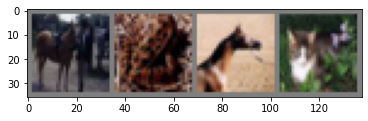

horse froghorse  cat


In [8]:
"""
加载数据
"""
# 导入库及下载数据
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data1', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data1', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 随机查看数据
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# 显示图像
def imshow(img):
    img = img  / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# 随机获取部分训练数据
dataiter = iter(trainloader)
images, labels = dataiter.next()
# 显示图像和标签
imshow(torchvision.utils.make_grid(images))
print(''.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
"""
构建网络
"""
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cpu")
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=36, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1296, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 36*6*6)
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return x
net = CNNNet()
net = net.to(device)
# 查看网络结构
print(net)
# 查看前四层
nn.Sequential(*list(net.children())[1:4])

CNNNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1296, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Sequential(
  (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (1): Conv2d(16, 36, kernel_size=(3, 3), stride=(1, 1))
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [26]:
# 初始化参数
for m in net.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight)
        nn.init.xavier_normal_(m.weight)
        nn.init.kaiming_normal_(m.weight) # 卷积层参数初始化
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight) # 全连接层参数初始化

In [34]:
"""
训练模型
"""
# 选择优化器
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# 训练模型
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取训练数据
        inputs, labels = data
        inouts, labels = inputs.to(device), labels.to(device)
        # 权重参数梯度清零
        optimizer.zero_grad()
        # 正向反向传播
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 显示损失值
        running_loss += loss.item()
        #if i % 10000 == 0:
        #    print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0
print('Finished Training')

Finished Training


In [35]:
"""
测试模型
"""
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(100*correct/total)
# 各个类别的准确率
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('%5s : %2d %%' % (classes[i], 100*class_correct[i]/class_total[i]))

67.43
plane : 70 %
  car : 87 %
 bird : 59 %
  cat : 50 %
 deer : 54 %
  dog : 59 %
 frog : 61 %
horse : 82 %
 ship : 80 %
truck : 68 %


In [30]:
"""
采用全局平均池化
"""
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cpu')
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 36, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.pool2 = nn.MaxPool2d(2, 2)
        # 使用全局平均池化
        self.aap = nn.AdaptiveAvgPool2d(1)
        self.fc3 = nn.Linear(36, 10)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.aap(x)
        x = x.view(x.shape[0], -1)
        x = self.fc3(x)
        return x
net = Net()
net = net.to(device)
# print(sum(x.numel() for x in net.parameters()))

In [33]:
"""
LeNet网络结构
"""
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 9, 5)
        self.conv2 = nn.Conv2d(9, 18, 5)
        self.fc1 = nn.Linear(18*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out